# <div style="text-align: center">Real Time Location System </div>
## <div style="text-align: center"> Predicting Location with K-Nearest Neighbor </div>
#### <div style="text-align: right"> Ryan Bass </div>
#### <div style="text-align: right"> Brett Benefield </div>

# Introduction

Reliable tracking inside buildings has become a major interest for companies to protect assets since wireless networking has grown and become cheaper. Indoor positioning systems (IPS) can utilize these wireless local area networks (LANs), combined with mobile tags and fixed location readers to accurately track items or even people indoors when the network is active using location sensing systems. These Real-Time Location Systems (RTLS), as the name suggests, can track these items/people in real time. The set up of an RTLS can vary greatly, but this case study's RTLS uses routers/access points (readers) to measure the strength of signal (location sensing system) from a hand held device (tag) and predict the device's location using the k-Nearest Neighbors algorithm.

To accurately track mobile tags through an environment though, reference spacial data is needed prior to the application of the intended system (offline data). This case study used a hallway on a particular floor at the University of Mannheim with 6 access points (routers) and 166 points in a grid of 1 meter apart from one another as tags. Signal strength was recorded for all points (x, y coordinates) and the orientation of the device (45 degree increments from 0 to 360). Based on this "offline" reference data the signal strenghts for the entire floor can be read and used to predict locations of tags of unknown locations.

Location prediction was tested in the case study's "online" data. 60 locations (not selected from the preivous 166 points but randomly in the hallway space) and orientation were randomly selected in the hallway and 110 signals were measured from then at each access point. This data set was used to determine the accuracy of our Real Time Location System models.

Here we have utilized a k-Nearest Neighbors alogrithm to quickly predict the location of these unknown devices. The case study found access points that were not intended to be in the data sets (a router that was on a different floor), those will be excluded and included in the model to examine which would be more accurate. The model will also be modified to increase the weight of predictions from access poitns that are closer to the unknown device. We will compare the accuracy from this model as well.

Before models could be tested though the data had to be cleaned and explored.

### Floor Plan Used for Predicting Location

![Floor Plan with Access Points](FloorPlan.png)

"Figure 1: Floor Plan of the Test Environment. In this floor plan, the 6 fixed access points are denoted by black square markers, the offline/training data were collected at the locations marked by grey dots, and the online measurements were recorded at randomly selected points indicated with black dots. The grey dots are spaced one meter apart." - Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving.

#### Orientation Effect on Signal Strength
Initial analysis in the case study researched if the orientation of a hand held device effected signal strength. To do this a single location was used and signal strength for it was measured when it was rotated 45 degrees (0 to 315, 360 would be the same as 0) at every access point in the experiment. The results can be seen in the figure below.

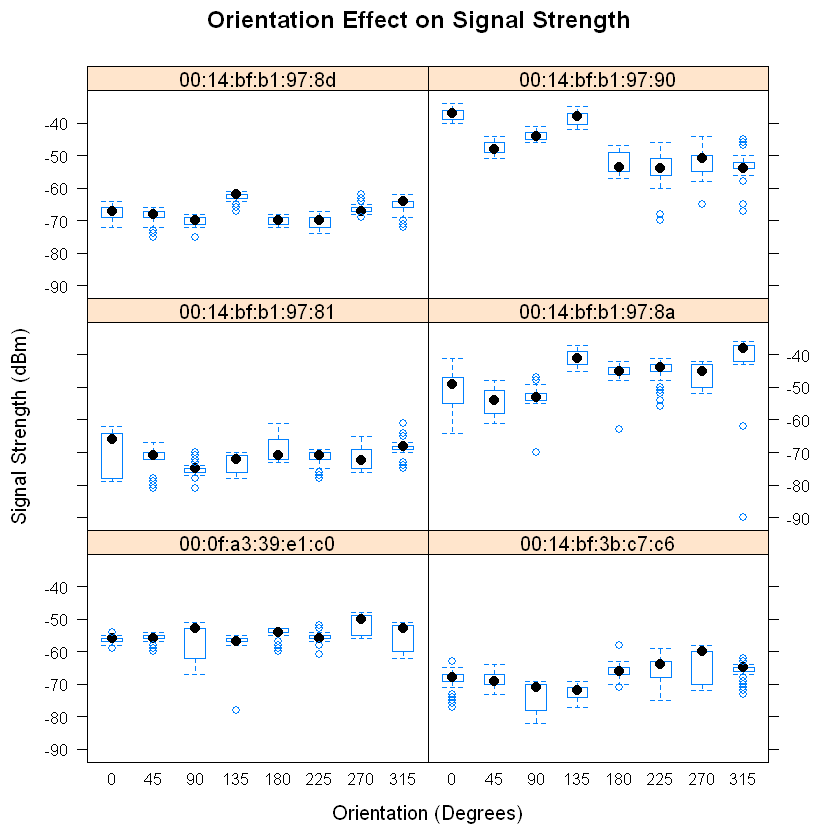

In [28]:
bwplot(signal ~ factor(angle) | mac, data = offline, subset = posX == 2 & posY == 12 & mac != "00:0f:a3:39:dd:cd", layout = c(2,3),
      main = "Orientation Effect on Signal Strength", xlab = "Orientation (Degrees)", ylab="Signal Strength (dBm)")

"Figure 2: Signal Strength by Angle for Each Access Point. The boxplots in this figure represent signals for one location, which is in the upper left corner of the floor plan, i.e., x = 2 and y = 12. These boxes are organized by access point and the angle of the hand-held device. The dependence of signal strength on angle is evident at several of the access points, e.g., 00:14:bf:97:90 in the top right panel of the figure." - Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving.

This result shows that orientation of a device (at least for this particular point but a strong assumption that the same holds true for the rest of the hallway) will effect its signal strength reading on any access point (near or far from the device).

In the case study there was a choice to drop an access point (MAC address: 00:0f:a3:39:dd:cd) in favor of another (MAC address: 00:0f:a3:39:e1:c0). This is due to the lack of signal reads and its proximity to the other access point. To explore if this dropped access point would be better at predicting our "online" data coordinates we will first explore it's characteristics to see if there are any anomoalies to be concerned about before using it in our model.

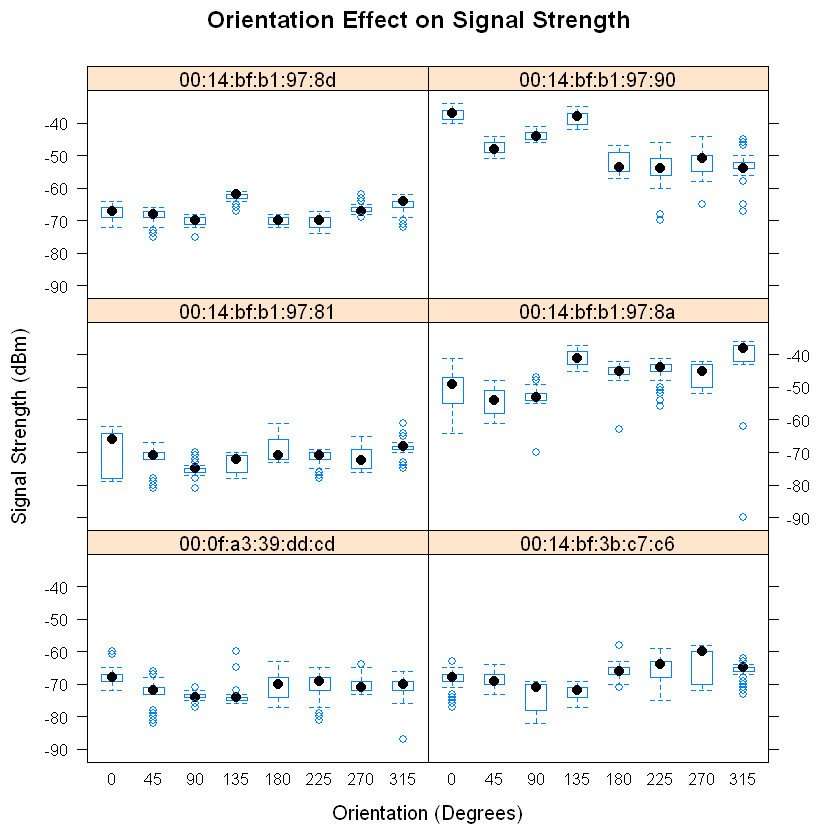

In [51]:
bwplot(signal ~ factor(angle) | mac, data = offline, subset = posX == 2 & posY == 12 & mac != "00:0f:a3:39:e1:c0", layout = c(2,3),
      main = "Orientation Effect on Signal Strength", xlab = "Orientation (Degrees)", ylab="Signal Strength (dBm)")

Figure 2.1 - Orientation vs Signal Strength which now includes the dropped MAC address.

We can see that the dropped access point's (MAC address: 00:0f:a3:39:dd:cd) readings of signal strengths is effected by the orientation of the tags as well.

#### Signal Strength, Density, and Orientation
Further analysis in the case study generated a density plot to display the signal strength distribution of a device at given angles read at every access point based on the device being at a single spot in the hallway.

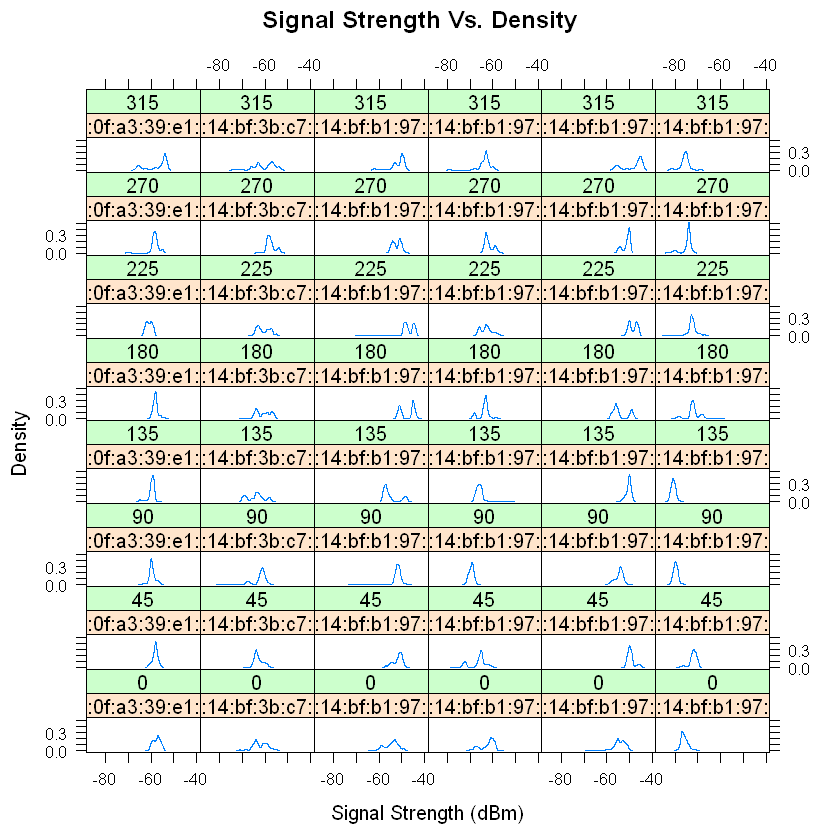

In [30]:
densityplot( ~ signal | mac + factor(angle), data = offline, subset = posX == 24 & posY == 4 & mac != "00:0f:a3:39:dd:cd", bw = 0.5, plot.points = FALSE,
           main = "Signal Strength Vs. Density", xlab = "Signal Strength (dBm)")

"Figure 3: Distribution of Signal by Angle for Each Access Point. The density curves shown here are for the signal strengths measured at the position: x = 24 and y = 4. These 48 density plots represent each of the access point × angle combinations. There are roughly 110 observations in each panel. Some look roughly normal while many others look skewed left." - Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving.

This result shows a mix of distributions. Mostly being normally distributed and left skewed while some are even bimodal.

We replot the data with the dropped access point (MAC address: 00:0f:a3:39:dd:cd) so we can look at its distribution as well.

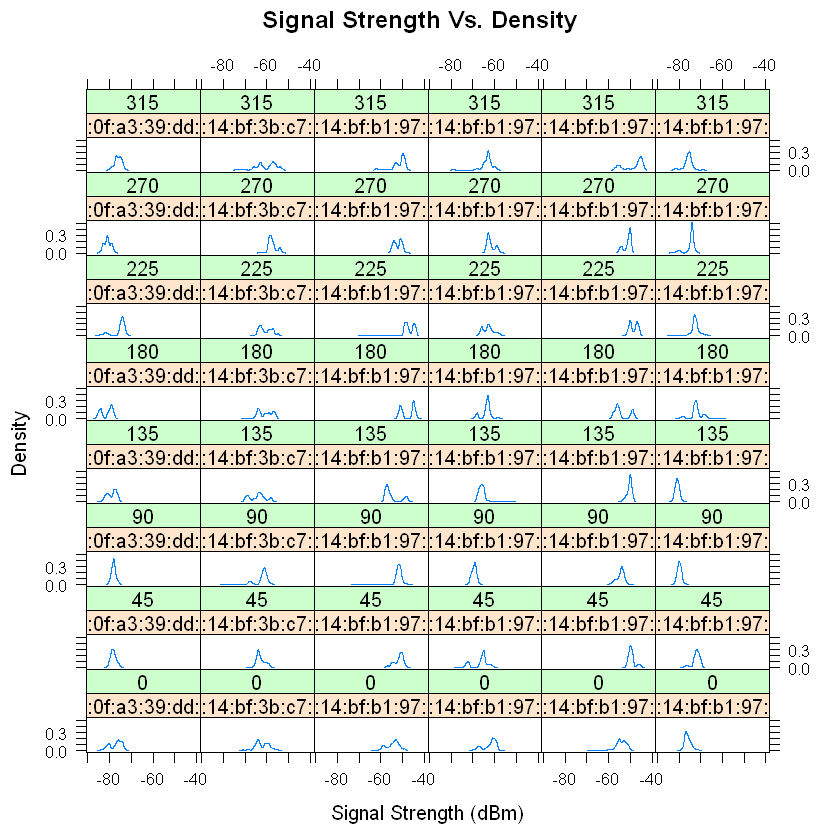

In [65]:
densityplot( ~ signal | mac + factor(angle), data = offline, subset = posX == 24 & posY == 4 & mac != "00:0f:a3:39:e1:c0", bw = 0.5, plot.points = FALSE,
           main = "Signal Strength Vs. Density", xlab = "Signal Strength (dBm)")

Figure 3.1 - Density vs Signal Strength which now includes the dropped MAC address.

It is a mostly normal distribution for every angle orientation of the tag but has one bimodal distribution. Comparing it to the access point that was kept in the original analysis in the case study (MAC address: 00:0f:a3:39:e1:c0) they are similar enough in their distribution shape's but differ in their strength. The smaller the absolute value of the signal strength is a stronger signal received. The dropped access point has a weaker signal strength when compared to the kept access point when this tag location of (24, 4) was used. Later in the analysis it will be shown that the location of the kept access point is (7.5, 6.3).

#### Signal Strength, Standard Deviation, and Outliers
Next the case study examined if there was a positive relationship between mean signal strength and standard deviation. It should be noted that the larger the magnitude equates to a weaker signal strength.

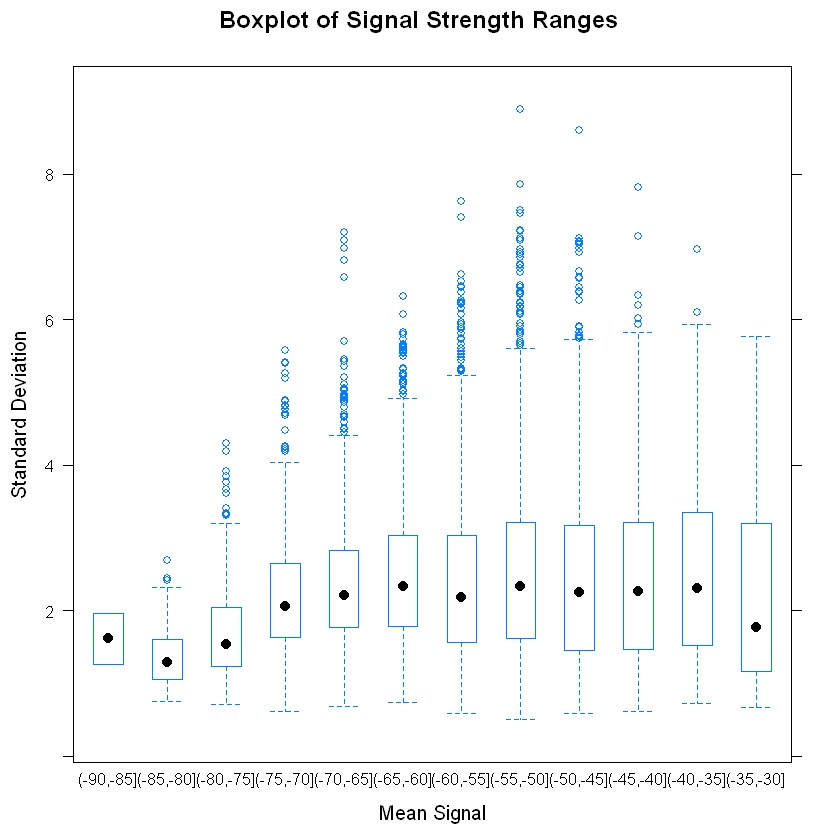

In [32]:
breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks), data = offlineSummary,subset = mac != DROPMAC, 
       main = "Boxplot of Signal Strength Ranges", xlab = "Mean Signal", ylab = "Standard Deviation")

"Figure 4: SD of Signal Strength by Mean Signal Strength. The average and SD for the signals detected at each location-angle-access point combination are plotted against each other. The weak signals have low variability and the stronger signals have greater variability." - Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving.

Indeed, a positive relationship can be seen here. As the signal strength increases, the standard deviation increases as well. This trend might plateau at around -40 to -35 signal strength and revert as the signal strength becomes strongest. This theoretical situation would seem to make sense as a device close to an access point would almost always have a strong signal strength.

#### Smoothed Scatter Plot Comparing Mean - Median Values
A smoothed scatter plot below shows the relationship between the mean and median values. The plot indicates that as the number of observations increase, the mean and median value converge.

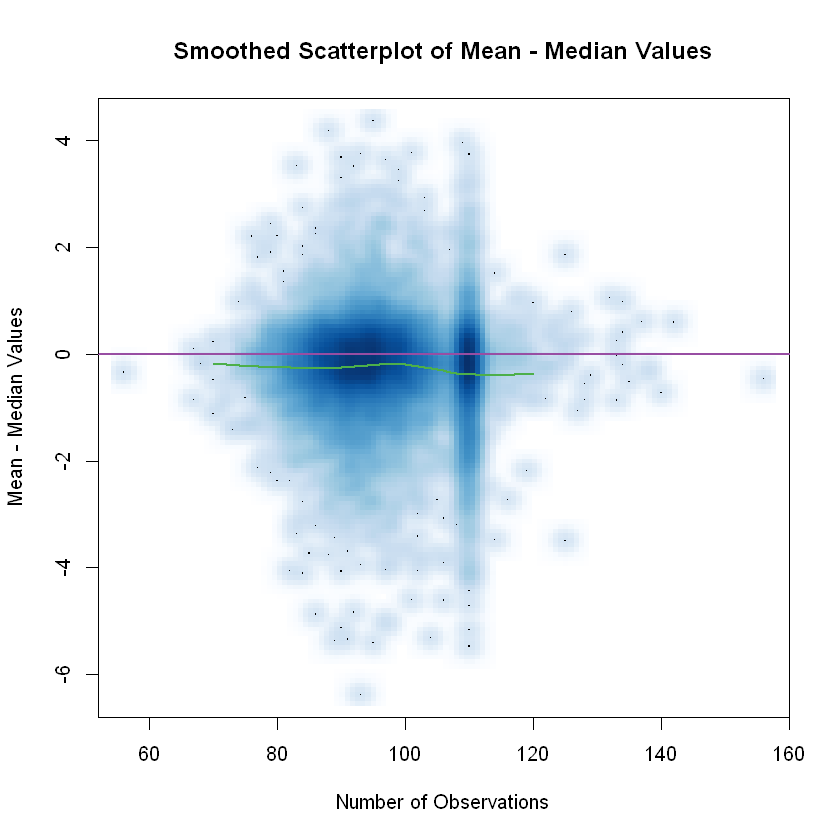

In [33]:
with(offlineSummary, smoothScatter((avgSignal - medSignal) ~ num, xlab = "Number of Observations", ylab = "Mean - Median Values", main = "Smoothed Scatterplot of Mean - Median Values"))
abline(h = 0, col = "#984ea3", lwd = 2)

lo.obj = with(offlineSummary, loess(diff ~ num, data = data.frame(diff = (avgSignal - medSignal), num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))

lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

"Figure 5: Comparison of Mean and Median Signal Strength. This smoothed scatter plot shows the difference between the mean and median signal strength for each combination of location, access point, and angle against the number of observations. These differences are close to 0 with a typical deviation of 1 to 2 dBm." - Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving.

#### Signal Strength Heat Map

Another way the case study visualized the relationship between distance and signal strength was to create a countour plot. These type of plots can help visualize the field strength measured at that location. As you move further away from those coordinates the field strength decreases as seen in the changing color. Like with the previous experiments, the orientation of the device is controlled.

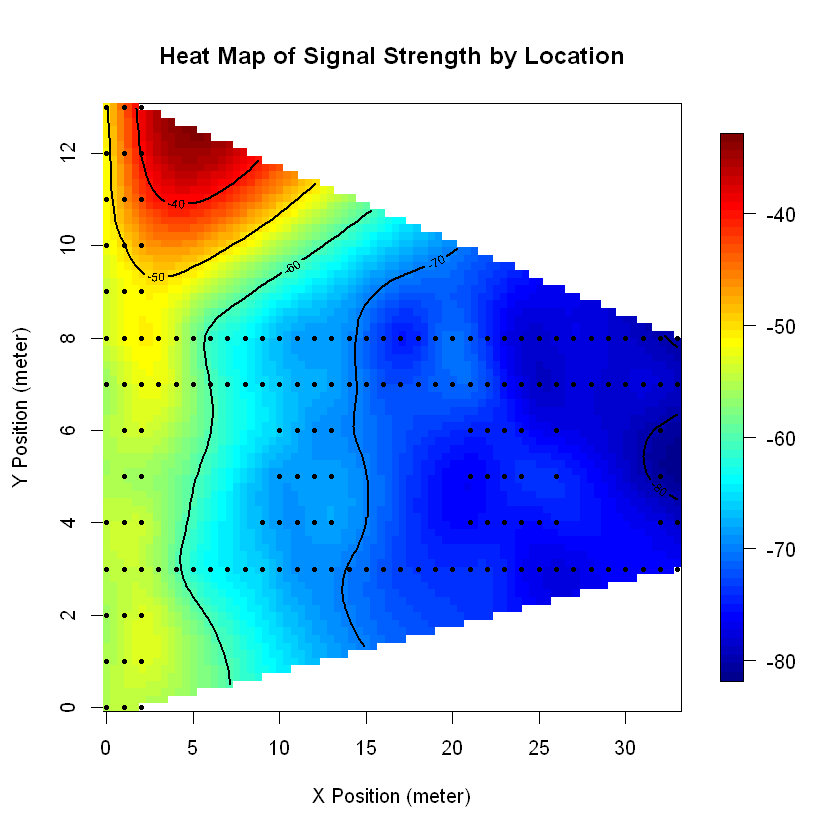

In [35]:
plot.surface(vizSmooth, type = "C", main = "Heat Map of Signal Strength by Location", xlab = "X Position (meter)", ylab="Y Position (meter)")
points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

Figure 6 - Heat Map of the Top Left Access Point

Another way to visualize signal strength along with the spatial information provided from the case study is a heat map. The fields R package is able to take a z value that would be used for the color in the heat map. The z in this data set will be the signal strength that is smoothed over to provide a topological map. From the case study they wanted to visualize two access points (MAC addresses: 00:14:bf:b1:97:90 across the top row and 00:0f:a3:39:e1:c0 across the bottom row) with two different angles (0 on the left and 135 on the right) with a subset of the offline data with the locations of the tags positioned on the grpah as well. The mean signal strength at each position recorded was smoothed out to create a more complete coverage of the graph visually even though the signal strengths are only being sent from specific x, y coordinates.

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL

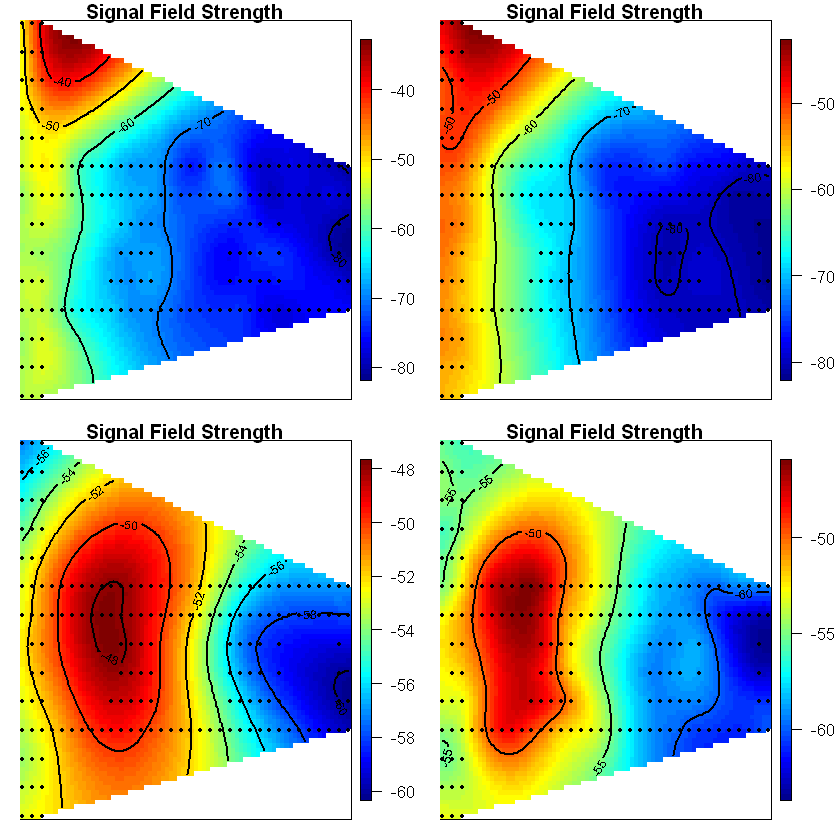

In [36]:
parCur = par(mfrow = c(2,2), mar = rep(1, 4))
mapply(surfaceSS, mac = subMacs[ rep(c(5, 1), each = 2) ], angle = rep(c(0, 135), 2), data = list(data = offlineSummary))
par(parCur)

"Figure 7: Median Signal at Two Access Points and Two Angles. These four heat maps provide a smooth topographical representation of signal strength. The top two maps are for the access point 00:14:bf:b1:97:90 and the angles 0 (left) and 135 (right). The two bottom heat maps represent the signal strength for the 00:0f:a3:39:e1:c0 and the same two angles." - Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving.

We can see how easy it is to identify which access point was being used from the initial diagram provided by the case study in Figure 7. The access point with MAC address 00:14:bf:b1:97:90 belongs to the router in the top left corner of the diagram while the MAC address 00:0f:a3:39:e1:c0 is in the upper horizontal hallway.

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:dd:cd`
NULL

$`00:0f:a3:39:dd:cd`
NULL

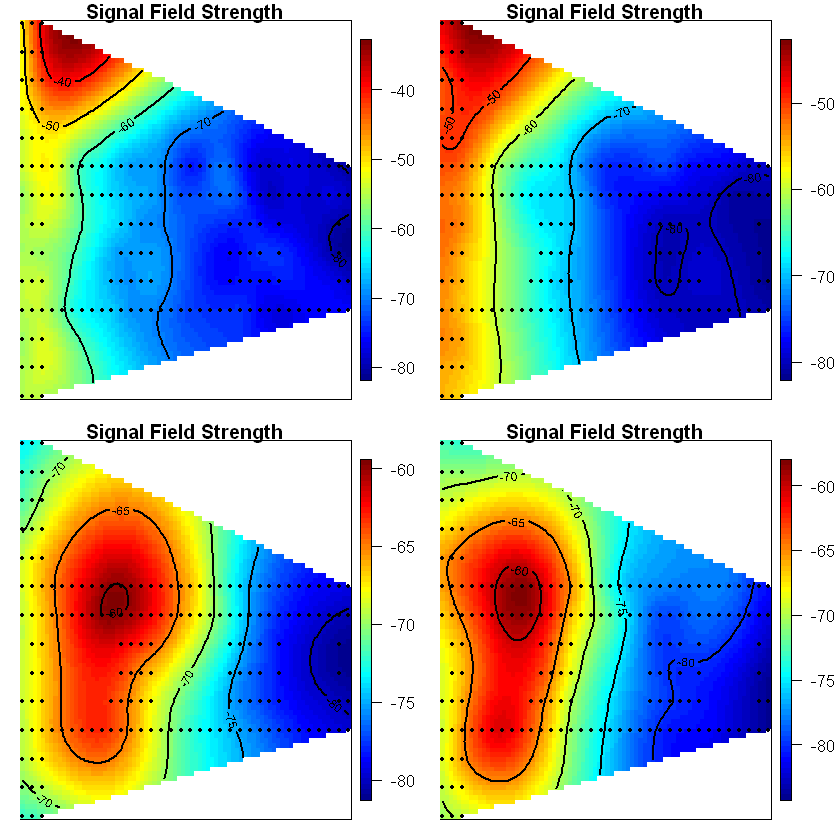

In [55]:
parCur = par(mfrow = c(2,2), mar = rep(1, 4))
mapply(surfaceSS, mac = subMacs[ rep(c(5, 2), each = 2) ], angle = rep(c(0, 135), 2), data = list(data = offlineSummary))
par(parCur)

Figure 7.1 - Heat map which now includes the dropped MAC address.

The heat map clearly shows a negative correlation between signal strength and increasing the distance between a tag and the access point. To visualize this for every access point and every angle orientiation provided in the data the author of the case study made a scatter plot of the distance between tags and the access point versus the signal strength reported from that tag.

Also provided in the code is the x, y coordinates of the access points as a list under apLocations. The MAC address 00:0f:a3:39:e1:c0 that is in the upper horizontal hallway from Figure 1.10 corresponds to x=7.5, y=6.3. From this knowledge we can work out all of the other x, y coordinates of the access points. The other MAC address (00:14:bf:b1:97:90) on the heat map then has to be x=1, y=14. Without graphing out heat maps for every MAC address, the coordinates for all of the access points were supplied in the matrix AP from the case study code:

|    Mac Address    | X Pos | Y Pos |
|:-----------------:|:-----:|:-----:|
| 00:0f:a3:39:e1:c0 |   7.5 |   6.3 |
| 00:14:bf:b1:97:8a |   2.5 |  -0.8 |
| 00:14:bf:b1:97:90 |   1.0 |  14.0 |
| 00:14:bf:b1:97:8d |  33.5 |   9.3 |
| 00:14:bf:b1:97:81 |  33.5 |   2.8 |
| 00:14:bf:3b:c7:c6 |  12.8 |  -2.8 |

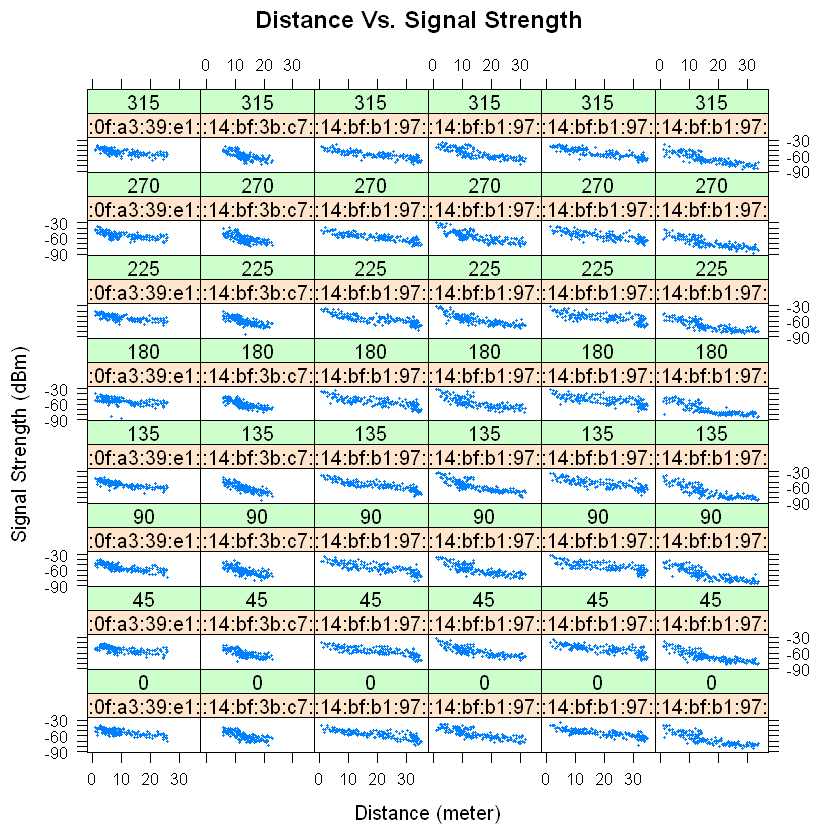

In [57]:
xyplot(signal ~ dist | factor(mac) + factor(angle), data = offlineSummary, pch = 19, cex = 0.3, main = "Distance Vs. Signal Strength", xlab ="Distance (meter)", ylab = "Signal Strength (dBm)")

"Figure 8: Signal Strength vs. Distance to Access Point. These 48 scatter plots show the relationship between the signal strength and the distance to the access point for each of the 6 access points and 8 orientations of the device. The shape is consistent across panels showing curvature in the relationship." - Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving.

As predicted from the heat map, there is a clear correlation between the distance between tags and access points and signal strength recorded for all access points and all of the orientations of the hand held device. There appears to be a slight curvature of the data but with a small dynamic range of values for the distance we do not believe a log transformation is needed. However, if the distance of the floor was larger we would likely need to log transform our data to visualize a linear relationship. As most particles that travel through space they will lose "strength" over time and distance. Radio frequencies (RF) are no different as the equation for their power level after it leaves an antenna is equal to 1/d<sup>2</sup>.

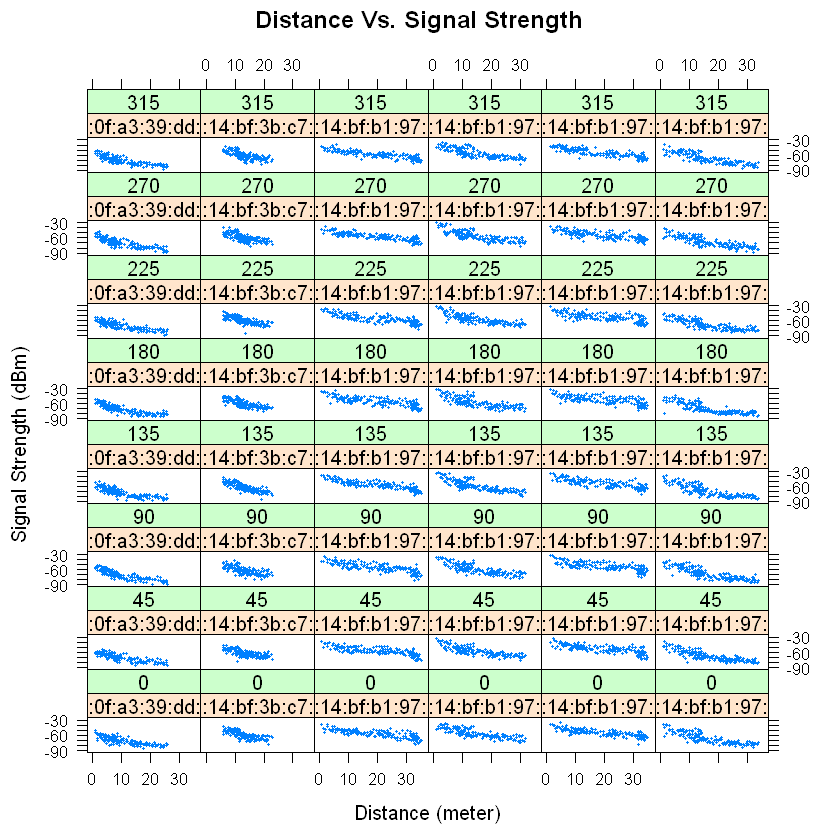

In [59]:
xyplot(signal ~ dist | factor(mac) + factor(angle), data = offlineSummary, pch = 19, cex = 0.3, main = "Distance Vs. Signal Strength", xlab ="Distance (meter)", ylab = "Signal Strength (dBm)")

Figure 8.1 - Distance Vs. Signal Strength which now includes the dropped MAC address.

Moving on to our "online" data set, randomly selected points were chosen for a handheld device and our model trained from the "offline" data set was used to predict the "online" selected point's coordinates. Like before the small grey circles are from the offline data that the model was trained on, the large black squares are the access points on the floor, the black circles are the actual randomly selected coordinates, the asterisks are the predicted coordinates from the model, and the red line links the actual versus predicted coordinates.

To predict these coordinates the case study utilized a k-Nearest Neighbors (kNN) algorithm. The top graph of Figure 1.12 is the model using a kNN with k=1 while the bottom is the model with k=3. The k in a kNN model can be changed to improve underfitting or reduce overfitting since k is the number of nearest points to the value being predicted. These k points around the predicted value can average their values to yield a prediction. In this example with a k of only 1, this would mean the offline coordinate of the nearest tag should be the prediction of the online device's coordinates. However, with a k of 3 the nearest 3 offline tag coordinates should average their coordinate predictions to yield the actual prediction.

null device 
          1

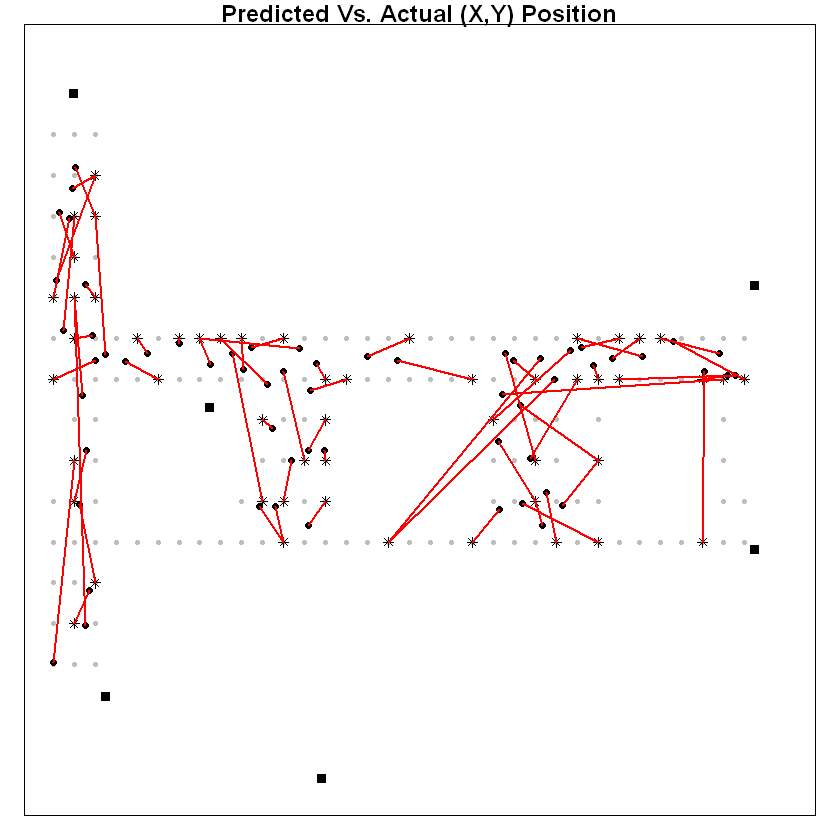

In [70]:
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

null device 
          1

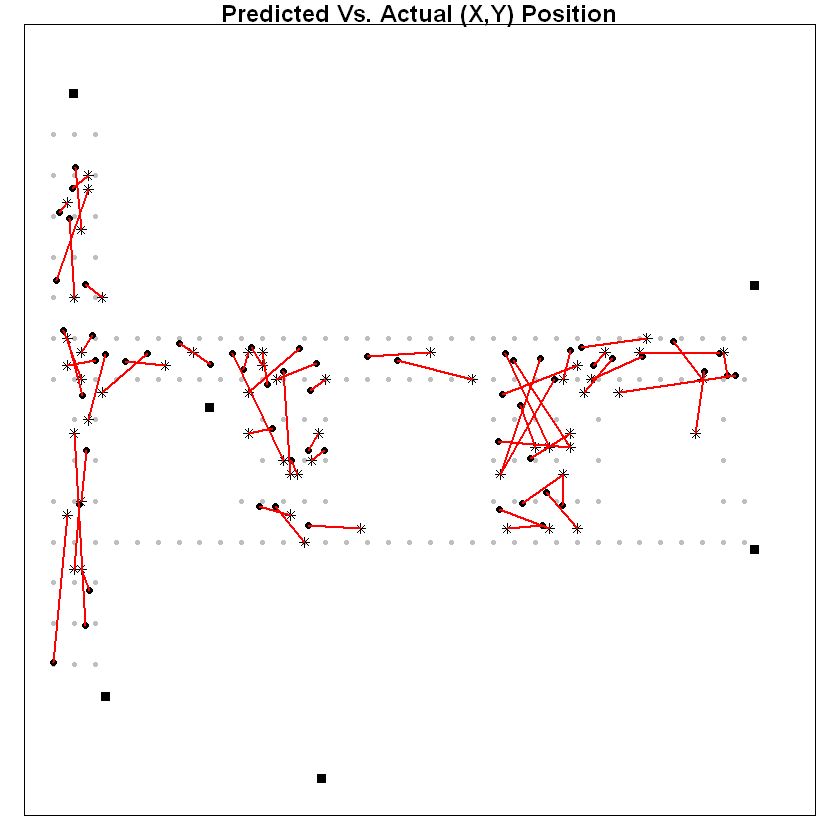

In [44]:
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

"Figure 9: Floor Plan with Predicted and Actual Locations. The red line segments shown in the floor plan connect the test locations (black dots) to their predicted locations (asterisks). The top plot shows the predictions for k = 1 and the bottom plot is for k = 3 nearest neighbors. In this model, we use as training data the average signal strengths from each of the 166 offline locations (grey dots) to the 6 access points (black squares) for the 3 closest angles to the angle at which the test data was measured." - Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving.

The k=1 kNN model (top graph) shows that the nearest tag from the offline coordinate was not actually used as the prediction for the online device's coordinates. This likely means that multiple tags from the offline data have signal strengths that are so close to one another that it would be hard for a model of k=1 to predict its location accurately. The most accurately predicted points look to be in the small vertical hallway on the diagram near the access point in the an adjacent room. All other access points are outside of the entire offline tag grid though so this is likely the cause of very bad prediction accuracy for the rest of the online coordinates.

The k=3 kNN model (bottom graph) looks as if it improves the accuracy of all predictions but the predictions on the online data that are still the most inaccurate look to be the ones at the bottom of the vertical hallway on the left of the diagram.

To confirm what looks to be true we can calculate the error of the predictions using the calcError function that takes the sum of the squared differences between the actual coordinates of the online coordinates versus the estimated coordinates from the model. This is the sum squared error.

In [22]:
actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)

[1] 659.4003 306.7025

The sum squared error of k=1 kNN is 659.4 while k=3 kNN is 306.7. This confirms that the k=3 kNN model does predict the online coordinates much better than the k=1 kNN model as predicted visually from Figure 1.12.

#### Model and Parameter Tuning

A range of k values were input to determine the appropriate number of neighbors that would give us the best classifcation and thus the lowest error value for our loss function. The case study used a range of k=1 to k=20 and plot out the values so we can see which k will yield the most accurate model.

### KNN with 00:0f:a3:39:dd:cd removed

NULL


null device 
          1

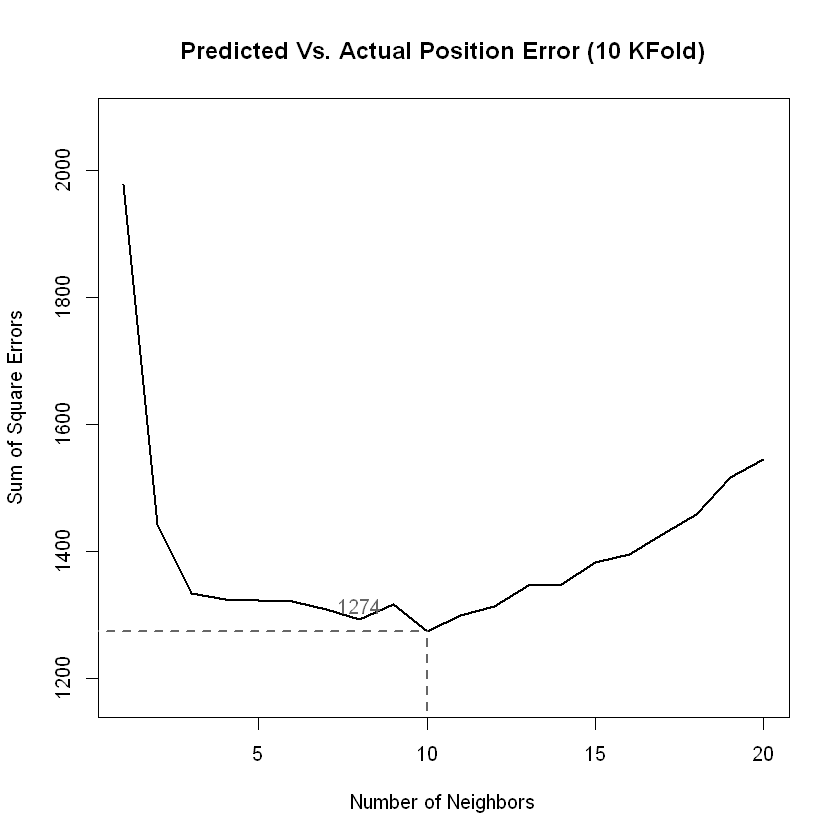

In [48]:
tmpPlot <- rmsePlot("00:0f:a3:39:dd:cd", offline = offline, fold = 10, K = 20, verbose = F)

oldPar = par(mar = c(4, 3, 1, 1))
print(tmpPlot)
par(oldPar)
dev.off()

### KNN with 00:0f:a3:39:e1:c0 removed

NULL


null device 
          1

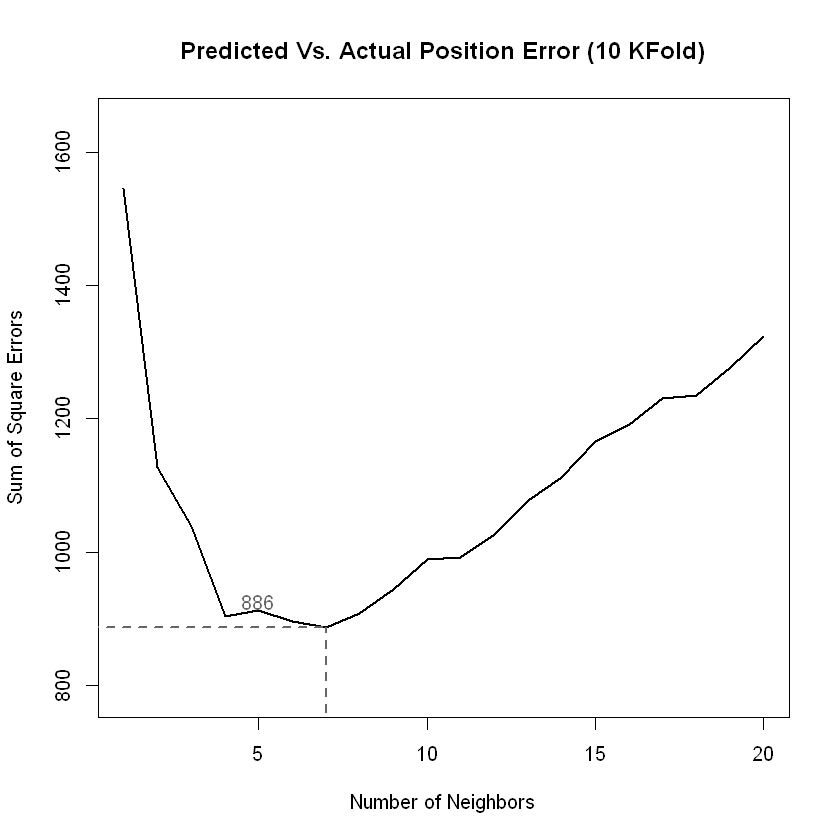

In [50]:
tmpPlot <- rmsePlot("00:0f:a3:39:e1:c0", offline = offline, fold = 10, K = 20, verbose = F)

oldPar = par(mar = c(4, 3, 1, 1))
print(tmpPlot)
par(oldPar)
dev.off()

### KNN with no APs Removed

NULL


null device 
          1

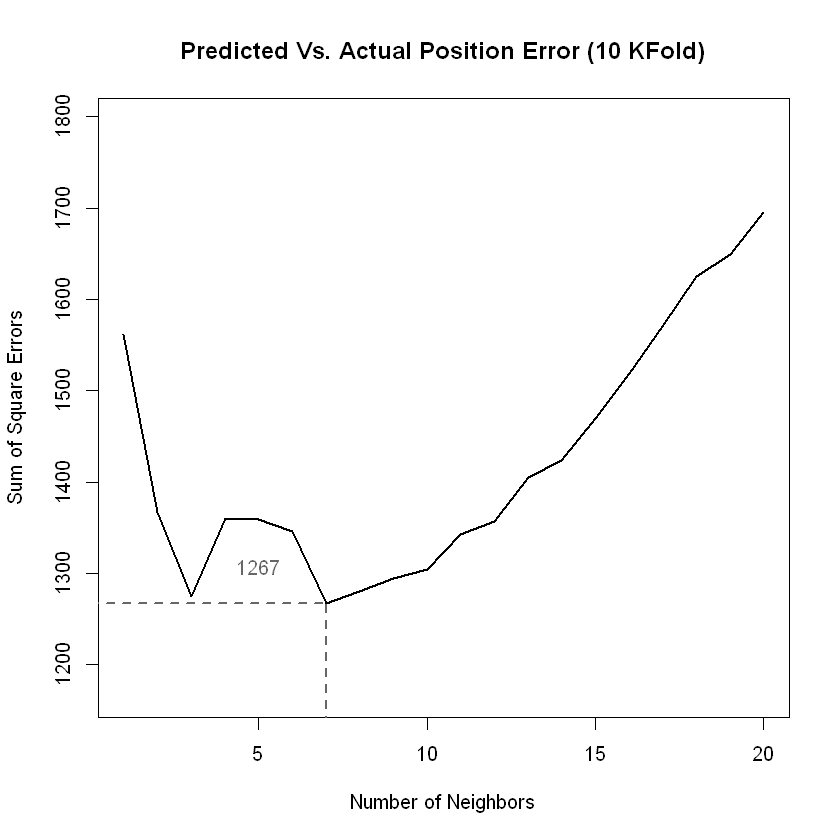

In [61]:
tmpPlot <- rmsePlot(offline = offline, fold = 10, K = 20, verbose = F)

oldPar = par(mar = c(4, 3, 1, 1))
print(tmpPlot)
par(oldPar)
dev.off()

#### Weighted K-Nearest Neighbor (KNN)
Weighted KNN uses the principles of KNN but applies a penalty to neighbors that are further away from the AP. The premise is that the closest value is most likely the correct value so we don't penalize that value. However, each additional value is penalized (weighted) by an increasing value to diminish its voting power on what AP the observation belongs to. The formula used for our weighted KNN is as follows:

$$y_i = {\sum(w_i)*(x_i)\over\sum(w_i)} $$

The results below show that in this sample, the weighted KNN performs slightly worse than when we excluded the "00:0f:a3:39:e1:c0" AP. Further analysis and verification will have to be performed on the models to confirm that our models are performing as expected.

### Weighted KNN with 00:0f:a3:39:dd:cd Removed

NULL


null device 
          1

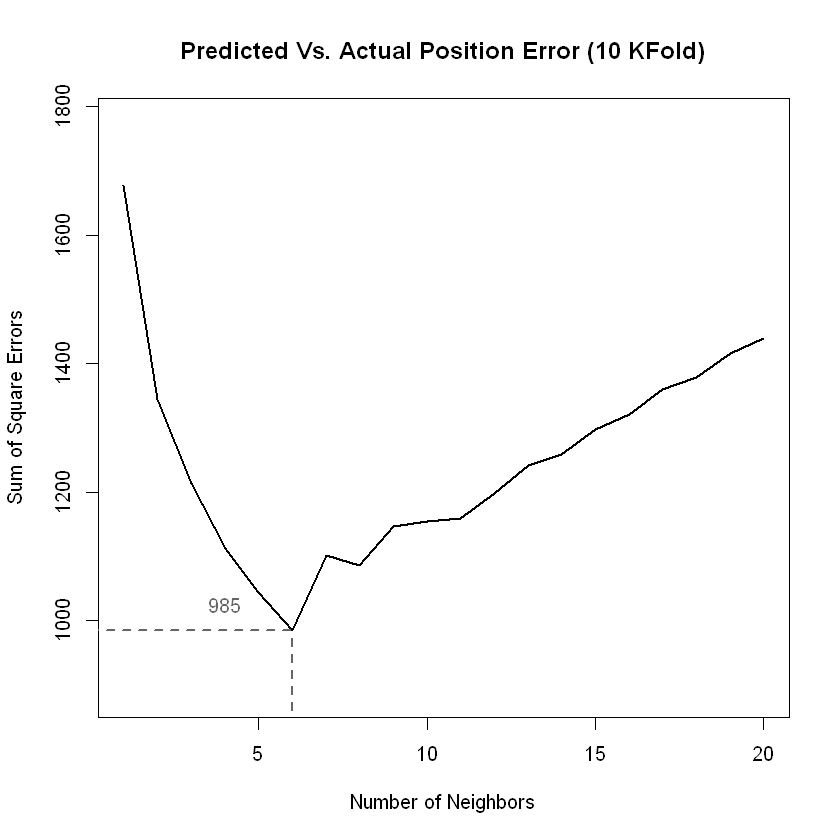

In [63]:
tmpPlot <- wrmsePlot("00:0f:a3:39:dd:cd", offline = offline, fold = 10, K = 20, verbose = F)

oldPar = par(mar = c(4, 3, 1, 1))
print(tmpPlot)
par(oldPar)
dev.off()

### Weighted KNN with 00:0f:a3:39:e1:c0 Removed

NULL


null device 
          1

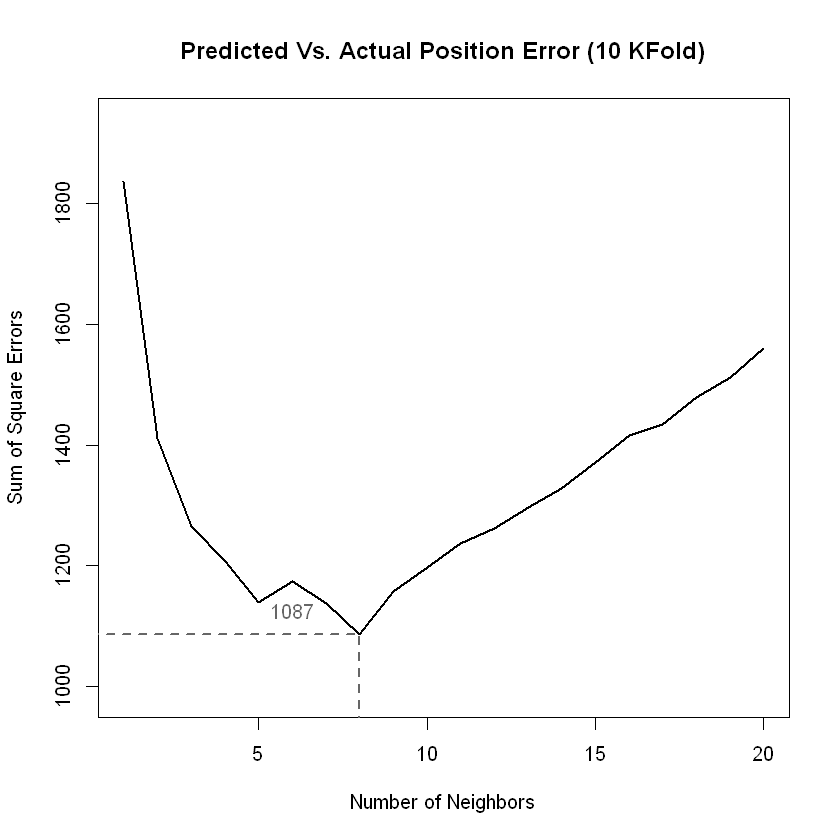

In [67]:
tmpPlot <- wrmsePlot("00:0f:a3:39:e1:c0", offline = offline, fold = 10, K = 20, verbose = F)

oldPar = par(mar = c(4, 3, 1, 1))
print(tmpPlot)
par(oldPar)
dev.off()

### Weighted KNN with no APs Removed

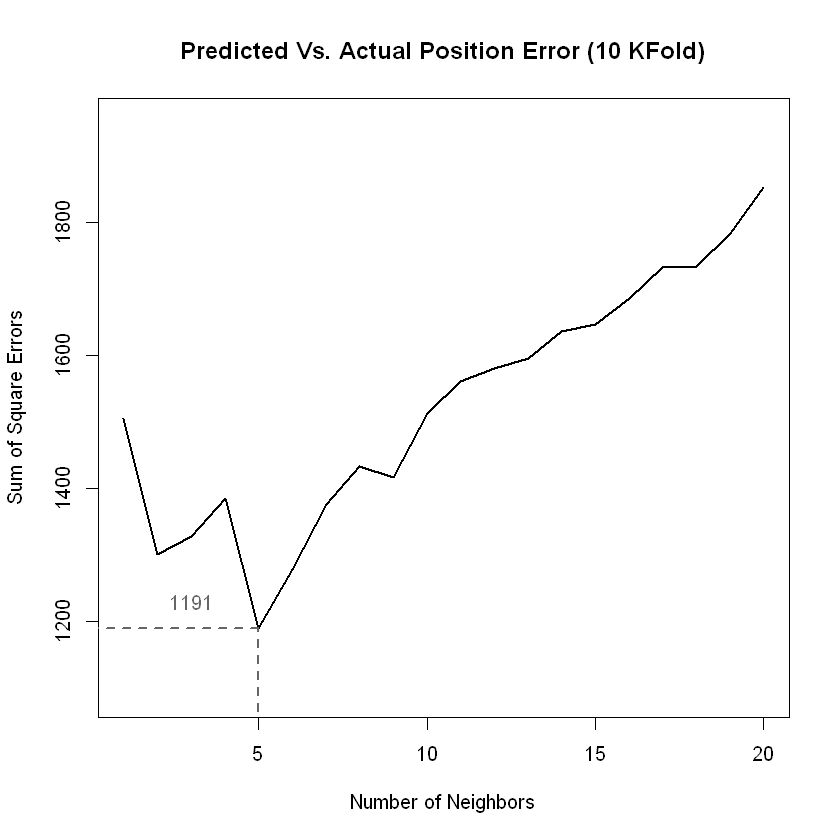

In [69]:
tmpPlot <- wrmsePlot("00:00:00:00:00:00", offline = offline, fold = 10, K = 20, verbose = F)

### Conclusion

In our results generated from both the case study and our own analysis we can see that the two access points in question (included MAC address 00:0f:a3:39:e1:c0 and dropped MAC address 00:0f:a3:39:dd:cd) have similar measured signal strength data. Both were effected by the orientation of a tag, and the distance between the tag and the AP weakened the signal strength observed. Both received approximately the same number of observations in the offline data (145,619 for 00:0f:a3:39:dd:cd and 145,862 for 00:0f:a3:39:e1:c0). This suggests that both Access Points are valid and should be kept in the observational data. A possible explanation for the difference between the two APs is that one is located on the floor above or below the tested floor. The main clue to where the dropped access point could be located would be to plot a heat map. This was alluded to on page 29 of the textbook Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving. It discusses that a similar heat map exists for another access point at the same position as the kept access point (00:0f:a3:39:e1:c0). This is the dropped access point (00:0f:a3:39:dd:cd), meaning is x, y coordinates are practically the same as the kept access point's. However, when we look at the KDE plots of Figure 3 and Figure 3.1 we can see that the dropped access point has a weaker signal strength distribution. Since they are both measuring a tag at a fixed location but the two access points x, y coordinates are nearly identical that can only mean that their z coordinates are different. This means that the dropped access point is on a different floor.

Because of this it would seem that the correct decision in the case study was made to keep the access point that was on the same floor as all the other access points for modeling purposes. One would predict that would yield a less accurate model if we included the access point that was from a different floor. We found that when we used the originally dropped access point instead of the originally kept access point the accuracy of the model decreased significantly. It seems like the dropped access point (00:0f:a3:39:dd:cd) is worse for location prediction. This increased distance away from the online and offline tags in the z direction thus led to the more innacurate RTLS.

When we used both of the access points in question for our kNN model we received roughly the same accuracy as the kNN model that used the different floor access point (00:0f:a3:39:dd:cd). With their SSEs only being 7 apart (1267 both included vs 1274 with the different floor access point) this is likely within the bounds of replication error. This clearly does not help location prediction under these parameters likely due to the strong bias of these two access points on the model in the middle of the hallway.

Lastly we included prediction models that utilized a weight kNN so the access points that are closest to the tags being predicted are weighted more heavily than access points further away. This followed a similar pattern as the unweighted kNN models with the access point originally kept in the case study yielding the most accurate model for location prediction. This however was not more accurate than the unweighted kNN models originally created in the case study. A table with the summary of the SSEs can be seen below.

|  Model  |      kNN      |  Weighted kNN |
|----------|:-------------:|------:|
| Same Floor | 886  | 985 |
| Different Floor |    1274   |   1087 |
| Both | 1267 |  1191   |

#### Sources

* Nolan, Debra. "Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving."
* http://rdatasciencecases.org/
* https://www.rdocumentation.org/
* https://stackoverflow.com/questions/1826519/how-to-assign-from-a-function-which-returns-more-than-one-value
* https://rstudio-pubs-static.s3.amazonaws.com/248376_c3c699140f4b4d7ba3f3e496dcedc99b.html
* http://www.data-machine.com/nmtutorial/instancebasedlearningandknearestneighboralgorithm.htm
* https://www.mathjax.org/

In [24]:
library(lattice)
library(fields)

# CONSTANTS
DROPMAC = "00:0f:a3:39:dd:cd"

processLine = function(x) {
  tokens = strsplit(x, "[;=,]")[[1]]
  
  if (length(tokens) == 10)
    return(NULL)
  
  tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, byrow = TRUE), tmp)
}

roundOrientation = function(angles) {
  refs = seq(0, by = 45, length = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

# Credit: https://stackoverflow.com/questions/1826519/how-to-assign-from-a-function-which-returns-more-than-one-value
readOnline <- function(dropMac = "00:00:00:00:00:00") {
  subMacs <- c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
              "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
              "00:14:bf:b1:97:81")

  # Drop requested mac
  subMacs <- subMacs[subMacs != dropMac]
  
  # Read in training dataset
  online = readData("online.txt", subMacs = subMacs)
  
  online$posXY = paste(online$posX, online$posY, sep = "-")
  
  tabonlineXYA = table(online$posXY, online$angle)
  
  keepVars = c("posXY", "posX","posY", "orientation", "angle")
  byLoc = with(online, by(online, list(posXY),
                          function(x) {
                            ans = x[1, keepVars]
                            avgSS = tapply(x$signal, x$mac, mean)
                            y = matrix(avgSS, nrow = 1, ncol = 6,
                                       dimnames = list(ans$posXY, names(avgSS)))
                            cbind(ans, y)
                          }
  ))
  onlineSummary = do.call("rbind", byLoc)
  
  return(list(online, onlineSummary))
  
}

readData <- function(filename = 'Data/offline.txt', 
                     subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                                 "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                                 "00:14:bf:b1:97:81")) {
  
  txt = readLines(filename)
  lines = txt[ substr(txt, 1, 1) != "#" ]
  tmp = lapply(lines, processLine)
  offline = as.data.frame(do.call("rbind", tmp), 
                          stringsAsFactors= FALSE) 
  
  names(offline) = c("time", "scanMac", 
                     "posX", "posY", "posZ", "orientation", 
                     "mac", "signal", "channel", "type")
  
  # keep only signals from access points
  offline = offline[ offline$type == "3", ]
  
  # drop scanMac, posZ, channel, and type - no info in them
  dropVars = c("scanMac", "posZ", "channel", "type")
  offline = offline[ , !( names(offline) %in% dropVars ) ]
  
  # drop more unwanted access points
  offline = offline[ offline$mac %in% subMacs, ]
  
  # convert numeric values
  numVars = c("time", "posX", "posY", "orientation", "signal")
  offline[ numVars ] = lapply(offline[ numVars ], as.numeric)
  
  # convert time to POSIX
  offline$rawTime = offline$time
  offline$time = offline$time/1000
  class(offline$time) = c("POSIXt", "POSIXct")
  
  # round orientations to nearest 45
  offline$angle = roundOrientation(offline$orientation)
  
  return(offline)
}

# Credit: https://rstudio-pubs-static.s3.amazonaws.com/248376_c3c699140f4b4d7ba3f3e496dcedc99b.html               
findWNN = function(newSignal, trainSubset) {
  dists = apply(trainSubset[ , 4:9], 1, function(x) sum( (x - newSignal)^2) )
  weights = 1/dists
  closest = order(dists)
  candidates = trainSubset[closest, 1:3]
  return(list(candidates, weights))
}

predWXY = function(newSignals, newAngles, trainData, 
                   numAngles = 1, k = 3) {
  
  closeXY <- list(length <- nrow(newSignals))
  weightXY <- list(length <- nrow(newSignals))

  for (i in 1:nrow(newSignals)) {
    trainSS <- selectTrain(newAngles[i], trainData, m = numAngles)
    tmpResult <- findWNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
    closeXY[[i]] <- tmpResult[[1]]
    weightXY[[i]] <- tmpResult[[2]]
  }
  
  wEstXY <- list(length <- length(weightXY))
  tmpXY <- list(length <- length(closeXY))
  
  for (i in 1:length(weightXY)){
    wDist <- list(length <- k)
    
    for (j in 1:k){
      wDist[j] <- (weightXY[[i]][j])/sum(weightXY[[i]][1:k])
    }
    
    wEstXY[[i]] <- wDist
  }
  
  for(i in 1:length(closeXY)){
    tmpXY[[i]] <- as.matrix(closeXY[[i]][1:k,2:3]) * unlist(wEstXY[[i]])
  }
  
  estXY <- lapply(tmpXY, function(x) apply(x, 2, function(x) sum(x)))
  
  estXY <- do.call("rbind", estXY)
  
  return(estXY)
}

findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }
  
  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
  plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n", main = "Predicted Vs. Actual (X,Y) Position",
       xlab = "X Position", ylab = "Y Position", axes = FALSE)
  box()
  if ( !is.null(AP) ) points(AP, pch = 15)
  if ( !is.null(trainPoints) )
    points(trainPoints, pch = 19, col="grey", cex = 0.6)
  
  points(x = actualXY[, 1], y = actualXY[, 2], 
         pch = 19, cex = 0.8 )
  points(x = estXY[, 1], y = estXY[, 2], 
         pch = 8, cex = 0.8 )
  segments(x0 = estXY[, 1], y0 = estXY[, 2],
           x1 = actualXY[, 1], y1 = actualXY[ , 2],
           lwd = 2, col = "red")
}

calcError = function(estXY, actualXY) {
  sum( rowSums( (estXY - actualXY)^2) )
}

selectTrain = function(angleNewObs, signals = NULL, m = 1) {
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

surfaceSS <- function(data, mac, angle = 45, title = main) {
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", main = "Signal Field Strength",
               xlab = "X Position (meter)", ylab = "Y Position (meter)", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  
  byLocation <- with(data, by(data, list(posXY), 
                              
                              function(x) {
                                if (sampleAngle) {
                                  x = x[x$angle == sample(refs, size = 1), ]
                                }
                                
                                ans = x[1, keepVars]
                                avgSS = tapply(x[ , varSignal ], x$mac, mean)
                                numCol <- length(avgSS)
                                y = matrix(avgSS, nrow = 1, ncol = numCol, dimnames = list(ans$posXY, names(avgSS)))
                                
                                cbind(ans, y)
                              }))
  
  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

rmsePlot = function(mac = "00:00:00:00:00:00", offline = offline, fold = 11, K = 20, verbose = FALSE) {

  tmpOffline = offline[ offline$mac != mac, ]
  
  keepVars = c("posXY", "posX","posY", "orientation", "angle")
  
  
  onlineCVSummary = reshapeSS(tmpOffline, keepVars = keepVars, 
                              sampleAngle = TRUE)
  
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , 1])
  
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -1])
  
  estFold = predXY(newSignals = onlineFold[ , 6:11], 
                   newAngles = onlineFold[ , 4], 
                   offlineFold, numAngles = 3, k = 3)
  
  actualFold = onlineFold[ , c("posX", "posY")]
  calcError(estFold, actualFold)
  
  err = rep(0, K)
  
  for (j in 1:fold) {
    if (verbose) {
      tmpOutput <- paste("Calculating RMSE for fold: ", j)
      message(tmpOutput)
    }
    
    onlineFold = subset(onlineCVSummary, 
                        posXY %in% permuteLocs[ , j])
    offlineFold = subset(offlineSummary,
                         posXY %in% permuteLocs[ , -j])
    actualFold = onlineFold[ , c("posX", "posY")]
    
    for (k in 1:K) {
      estFold = predXY(newSignals = onlineFold[ , 6:11],
                       newAngles = onlineFold[ , 4], 
                       offlineFold, numAngles = 3, k = k)
      err[k] = err[k] + calcError(estFold, actualFold)
    }
  }
  
  return(showPlot(err, K))
}

wrmsePlot <- function(mac = "00:00:00:00:00:00", offline = offline, fold = 11, K = 20, verbose = FALSE) {
  K = K
  v = fold
  
  tmpOffline = offline[ offline$mac != mac, ]
  
  keepVars = c("posXY", "posX","posY", "orientation", "angle")
  
  
  onlineCVSummary = reshapeSS(tmpOffline, keepVars = keepVars, 
                              sampleAngle = TRUE)
  
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , 1])
  
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -1])
  
  estFold = predWXY(newSignals = onlineFold[ , 6:11], 
                    newAngles = onlineFold[ , 4], 
                    offlineFold, numAngles = 3, k = 3)
  
  actualFold = onlineFold[ , c("posX", "posY")]
  calcError(estFold, actualFold)
  
  err = rep(0, K)
  
  for (j in 1:v) {
    if (verbose) {
      tmpOutput <- paste("Calculating RMSE for fold: ", j)
      message(tmpOutput)
    }
    
    onlineFold = subset(onlineCVSummary, 
                        posXY %in% permuteLocs[ , j])
    offlineFold = subset(offlineSummary,
                         posXY %in% permuteLocs[ , -j])
    actualFold = onlineFold[ , c("posX", "posY")]
    
    for (k in 1:K) {
      estFold = predWXY(newSignals = onlineFold[ , 6:11],
                        newAngles = onlineFold[ , 4], 
                        offlineFold, numAngles = 3, k = k)
      err[k] = err[k] + calcError(estFold, actualFold)
    }
  }
  
  return(showPlot(err, K))
}

showPlot = function(err, K) {
  tmpPlot <- plot(y = err, x = (1:K),  type = "l", lwd= 2,
                  ylim = c(min(err) - 100, max(err) + 100),
                  main = "Predicted Vs. Actual Position Error (10 KFold)",
                  xlab = "Number of Neighbors",
                  ylab = "Sum of Square Errors")
  
  rmseMin = min(err)
  kMin = which(err == rmseMin)[1]
  segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
           lty = 2, lwd = 2)
  segments(x0 = kMin, x1 = kMin, y0 = rmseMin - 150,  y1 = rmseMin, 
           col = grey(0.4), lty = 2, lwd = 2)
  
  text(x = kMin - 2, y = rmseMin + 40, 
       label = as.character(round(rmseMin)), col = grey(0.4))
  
  return(tmpPlot)
}

resetData <- function(dropMac = "00:00:00:00:00:00") {
  apLocation <- c()
  offline <- readData("offline.txt")
  
  subMacs = names(sort(table(offline$mac), decreasing = TRUE))[1:7]
  offline = offline[ offline$mac %in% subMacs, ]
  
  offline$posXY = paste(offline$posX, offline$posY, sep = "-")
  byLocAngleAP = with(offline, by(offline, list(posXY, angle, mac), function(x) x))
  
  signalSummary = lapply(byLocAngleAP, function(oneLoc) {
    ans = oneLoc[1, ]
    ans$medSignal = median(oneLoc$signal)
    ans$avgSignal = mean(oneLoc$signal)
    ans$num = length(oneLoc$signal)
    ans$sdSignal = sd(oneLoc$signal)
    ans$iqrSignal = IQR(oneLoc$signal)
    ans
  })
  
  offlineSummary = do.call("rbind", signalSummary)
  
  offlineSummary = subset(offlineSummary, mac != dropMac)
  
  subMacs <- subMacs[subMacs != dropMac]
  
  if (dropMac == "00:00:00:00:00:00") {
    apLocation <- c( 7.5, 6.3, 7.5, 6.3, 2.5, -.8, 12.8, -2.8, 1, 14, 33.5, 9.3,  33.5, 2.8)
  } else {
    apLocation <- c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8, 1, 14, 33.5, 9.3,  33.5, 2.8)
  }
  
  AP = matrix( apLocation, ncol = 2, byrow = TRUE, dimnames = list(subMacs, c("x", "y") ))
  
  diffs = offlineSummary[ , c("posX", "posY")] - AP[ offlineSummary$mac , ]
  
  offlineSummary$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)
  
  return(list(offline, offlineSummary))
}

# Read in dataset
offline <- readData("offline.txt")
                                  
# Create a column composed of X-Y permutations
offline$posXY = paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP = with(offline, by(offline, list(posXY, angle, mac), function(x) x))

# Calculate statistics for each AP
signalSummary = lapply(byLocAngleAP, function(oneLoc) {
  ans = oneLoc[1, ]
  ans$medSignal = median(oneLoc$signal)
  ans$avgSignal = mean(oneLoc$signal)
  ans$num = length(oneLoc$signal)
  ans$sdSignal = sd(oneLoc$signal)
  ans$iqrSignal = IQR(oneLoc$signal)
  ans
})

# Append summary to dataframe
offlineSummary <- do.call("rbind", signalSummary)

# Drop mac from dataset
offlineSummary <- subset(offlineSummary, mac != DROPMAC)

In [34]:
# Sort by row count and keep top 7 AP mac addy
subMacs <- names(sort(table(offline$mac), decreasing = TRUE))[1:7]

# Drop AP from list of mac addys
filteredMacs <- subMacs[subMacs != DROPMAC]

# Remove all rows except those identified above
offline = offline[ offline$mac %in% filteredMacs, ]

# Look at a single AP & angle
oneAPAngle = subset(offlineSummary, mac == subMacs[5] & angle == 0)
smoothSS = Tps(oneAPAngle[, c("posX","posY")], oneAPAngle$avgSignal)

vizSmooth = predictSurface(smoothSS)

In [43]:
offlineSummary = subset(offlineSummary, mac != DROPMAC)

# x & y location of APs
apLocations = c(7.5, 6.3, 2.5, -.8, 12.8, -2.8, 1, 14, 33.5, 9.3,  33.5, 2.8)

# Create a matrix with x & y locations of AP macs using their names
# Don't include '00:0f:a3:39:dd:cd' mac
AP = matrix(apLocations, ncol = 2, byrow = TRUE, dimnames = list(filteredMacs, c("x", "y") ))

# Subtract x & y positions
diffs = offlineSummary[ , c("posX", "posY")] - AP[ offlineSummary$mac , ]

# Determine cartesian distance from first and second mac AP
offlineSummary$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)

In [41]:
# Read testing data
onlineResult <- readOnline(DROPMAC)
online <- onlineResult[[1]]
onlineSummary <- onlineResult[[2]]

# Not sure what this is doing, may explore later
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

offlineSubset = offlineSummary[ offlineSummary$angle %in% angles, ]

trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

train130 = selectTrain(130, offlineSummary, m = 3)

estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)

trainPoints = offlineSummary[ offlineSummary$angle == 0 & offlineSummary$mac == "00:0f:a3:39:e1:c0" , c("posX", "posY")]

In [56]:
# Set seed for reproducibiltiy
set.seed(314)

# Reset training data
offlineResult <- resetData("00:0f:a3:39:dd:cd")
offline <- offlineResult[[1]]
offlineSummary <- offlineResult[[2]]

# Reset testing data
onlineResult <- readOnline("00:0f:a3:39:dd:cd")
online <- onlineResult[[1]]
onlineSummary <- onlineResult[[2]]
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = 11, nrow = floor(length(permuteLocs)/11))
onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

Warning message in matrix(permuteLocs, ncol = 11, nrow = floor(length(permuteLocs)/11)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"

In [64]:
# Reset training data
offlineResult <- resetData("00:0f:a3:39:e1:c0")
offline <- offlineResult[[1]]
offlineSummary <- offlineResult[[2]]

# Reset testing data
onlineResult <- readOnline("00:0f:a3:39:e1:c0")
online <- onlineResult[[1]]
onlineSummary <- onlineResult[[2]]
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = 11, nrow = floor(length(permuteLocs)/11))
onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

Warning message in matrix(permuteLocs, ncol = 11, nrow = floor(length(permuteLocs)/11)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"

In [60]:
# Reset training data
offlineResult <- resetData()
offline <- offlineResult[[1]]
offlineSummary <- offlineResult[[2]]

In [62]:
# Reset training data
offlineResult <- resetData("00:0f:a3:39:dd:cd")
offline <- offlineResult[[1]]
offlineSummary <- offlineResult[[2]]

# Reset testing data
onlineResult <- readOnline("00:0f:a3:39:dd:cd")
online <- onlineResult[[1]]
onlineSummary <- onlineResult[[2]]
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = 11, nrow = floor(length(permuteLocs)/11))
onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

Warning message in matrix(permuteLocs, ncol = 11, nrow = floor(length(permuteLocs)/11)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"